In [1]:
import rank
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import numpy as np
import cv2

In [13]:
#query_path = 'datasets/Brueghel/Winter Village Landscape with Ice Skating.jpg'
#query_path = 'datasets/Brueghel/Wide Landscape with Wagon and Travelers (London).jpg'
#query_path = 'datasets/Brueghel/Winter (Braunschweig).jpg'
#query_path = '/home/annab/Durham2024/datasets/Brueghel/A Bridal Feast (Unknown).jpg'
#query_path = 'datasets/Brueghel/Wide River Landscape with Resting Travelers.jpg' ##INTERSTING#
#query_path = 'datasets/Brueghel/A River Landscape.jpg'
query_path = 'datasets/Brueghel/Wedding Celebration in a Barn (Sotheby\'s, London 2002).jpg'
#query_path = 'datasets/Brueghel/Village Street with Dancing Peasants.jpg'
#query_path = 'datasets/Brueghel/View Down a River through a Village.jpg'
top_matches = rank.cos_sim(query_path, 'embeddings/Brueghel_conc.pkl')

73 detections found for query
(73, 36113)


In [ ]:
for query, matches in top_matches:
   print(f"Query: {query['box']}")
   for match, similarity in matches:
       print(f"Match: {match['image_path'], match['box']} with similarity {similarity}")


In [181]:
#OBSOLETE

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(dictionary_list, color_list, figsize, alpha = 0):
    # Ensure there is at least one dictionary in the list
    if not dictionary_list:
        print("No data to draw.")
        return
    
    # Load the first image from the list
    image_path = dictionary_list[0]['image_path']
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    
    # Create a figure and axis to display the image
    fig, ax = plt.subplots(figsize = figsize)
    ax.imshow(image)
    ax.axis('off')

    # Draw all bounding boxes
    for i, dictionary in enumerate(dictionary_list):
        x1, y1, x2, y2 = dictionary['box']
        x1 = int(x1 * width)
        y1 = int(y1 * height)
        x2 = int(x2 * width)
        y2 = int(y2 * height)

        # Draw the bounding box outline
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=1, edgecolor=color_list[i], facecolor='none',
            alpha=1
        )
        ax.add_patch(rect)

        # Draw the bounding box fill
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='none', facecolor=color_list[i],
            alpha= alpha
        )
        ax.add_patch(rect)

    plt.tight_layout()
    plt.show()



In [8]:
#OBSOLETE
def most_matched_images(top_matches, n_images, n_boxes):
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(np.linspace(0, 1, n_boxes))

    counter = Counter()
    
    # Iterate through each query embedding's matches
    for _, matches in top_matches:
        for match_embedding_dict, _ in matches:
            counter[match_embedding_dict['image_path']] += 1

    # Find the most common image path
    most_common_image_paths = counter.most_common(n_images)
    print('top matches: ', most_common_image_paths)

    top_matches_on_most_common_images = []
    
    for img in most_common_image_paths:
        top_matches_curr_img = []
        for query_embedding_dict, matches in top_matches:
            for match_embedding_dict, similarity in matches:
                if match_embedding_dict['image_path'] == img[0]:
                    top_matches_curr_img.append(((query_embedding_dict, match_embedding_dict), similarity))
        ##sort according to the value of similarity           
        top_matches_curr_img.sort(key=lambda x: x[1], reverse=True)
        top_matches_on_most_common_images.append(top_matches_curr_img)



    for curr_img in top_matches_on_most_common_images:

        query_embedding_dicts= [query_embedding_dict for (query_embedding_dict, match_embedding_dict), similarity in curr_img]
        match_embedding_dicts= [match_embedding_dict for (query_embedding_dict, match_embedding_dict), similarity in curr_img]
        sim_list= [similarity for (query_embedding_dict, match_embedding_dict), similarity in curr_img]
        print(sim_list)
        

        figsize = (n_images*6, n_images*3)
    
        draw_bounding_boxes(query_embedding_dicts[:n_boxes]+1, colors, figsize) # type: ignore
        draw_bounding_boxes(match_embedding_dicts[:n_boxes+1], colors, figsize)
 

In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import numpy as np

def draw_bounding_boxes(image_path, boxes, colors, tags = None, alpha=0, offset=2):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.imshow(image)
    ax.axis('off')

    offsets = np.zeros((len(boxes), 2))  # Array to keep track of offsets applied to each box

    for i, (x1, y1, x2, y2) in enumerate(boxes):
        x1 = int(x1 * width)
        y1 = int(y1 * height)
        x2 = int(x2 * width)
        y2 = int(y2 * height)

        # Apply an offset if this box overlaps with previously drawn boxes
        for j in range(i):
            prev_x1, prev_y1, prev_x2, prev_y2 = boxes[j]
            prev_x1 = int(prev_x1 * width) + offsets[j][0]
            prev_y1 = int(prev_y1 * height) + offsets[j][1]
            prev_x2 = int(prev_x2 * width) + offsets[j][0]
            prev_y2 = int(prev_y2 * height) + offsets[j][1]

            # Check for overlap
            if (x1 < prev_x2 and x2 > prev_x1 and y1 < prev_y2 and y2 > prev_y1):
                offsets[i] = [offsets[i][0] + offset, offsets[i][1] + offset]
        
        x1 += offsets[i][0]
        y1 += offsets[i][1]
        x2 += offsets[i][0]
        y2 += offsets[i][1]

        # Draw the bounding boxes
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor=colors[i], facecolor='none',
            alpha=1
        )
        ax.add_patch(rect)
        
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='none', facecolor=colors[i],
            alpha=alpha
        )
        ax.add_patch(rect)

        if tags is not None:
            ax.text(
                x1, y1 - 10, f'{tags[i]}', 
                color='white', fontsize=8, 
                bbox=dict(facecolor='black', alpha=0.4, pad=1)
            )

    plt.tight_layout()
    plt.show()

def most_matched_images(top_matches, n_images, n_boxes):
    query_path = top_matches[0][0]['image_path']
    
    counter = Counter()
    for _, matches in top_matches:
        for match_embedding_dict, _ in matches:
            counter[match_embedding_dict['image_path']] += 1

    most_common_image_paths = counter.most_common(n_images)
    print('Top matches:', most_common_image_paths)

    top_matches_on_most_common_images = []
    
    for img_path, _ in most_common_image_paths:
        matches_for_img = []
        for query_embedding_dict, matches in top_matches:
            for match_embedding_dict, similarity in matches:
                if match_embedding_dict['image_path'] == img_path:
                    matches_for_img.append((query_embedding_dict, match_embedding_dict, similarity))
        
        matches_for_img.sort(key=lambda x: x[2], reverse=True)
        top_matches_on_most_common_images.append(matches_for_img[:n_boxes])
    
    for matches in top_matches_on_most_common_images:
        query_boxes = [match[0]['box'] for match in matches]
        match_boxes = [match[1]['box'] for match in matches]
        similarities = [match[2] for match in matches]

        print(similarities)

        tags = [i for i in range(1, 100)]
        
        cmap = plt.get_cmap('coolwarm')
        colors = [cmap(max(0, min((similarity - 0.70) / 0.30, 1))) for similarity in similarities]


        
        if matches:
            image_path = matches[0][1]['image_path']
            draw_bounding_boxes(query_path, query_boxes, colors, offset=5, tags = tags)
            draw_bounding_boxes(image_path, match_boxes, colors, offset=5, tags = tags)


Top matches: [('datasets/Brueghel/Cityscape with Busy Street.jpg', 25), ('datasets/Brueghel/The Palace of Isabella Clara Eugenia at Tervuren.jpg', 19)]
[0.8599124632931332, 0.7664338641468603, 0.759719181370964, 0.7376396433148821, 0.7362199790126693, 0.7351584210766252, 0.7200503762583683, 0.716697109931696, 0.7160212035775355, 0.7146760293744919, 0.7065933009499535, 0.6959615087192793, 0.6937047526400756, 0.6852206711357142, 0.6826314831476362, 0.6710527004091098, 0.6708956040570643, 0.6707772003562148, 0.6665680424402575, 0.6632323889948656]


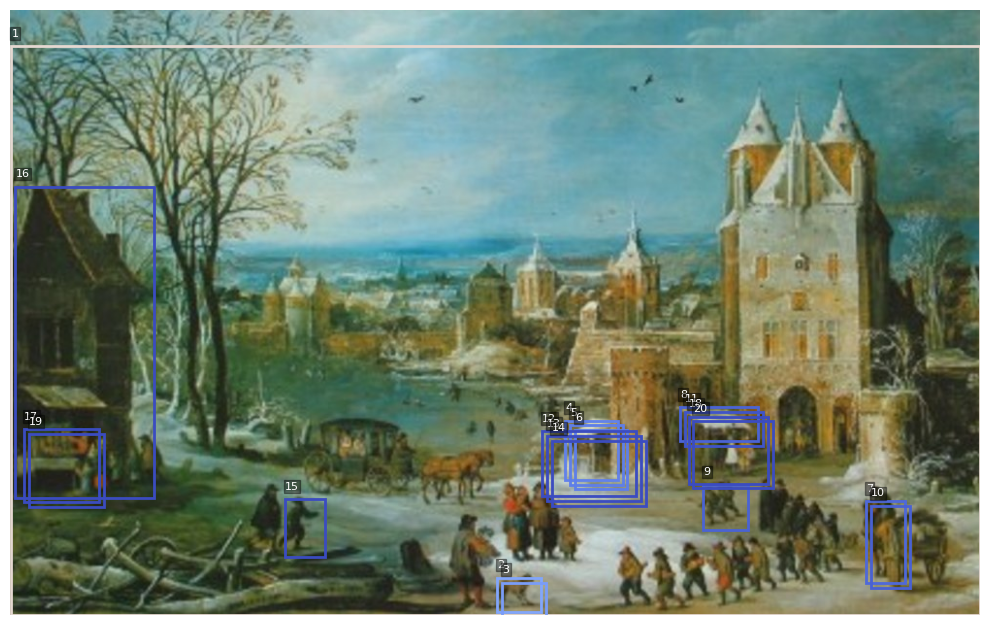

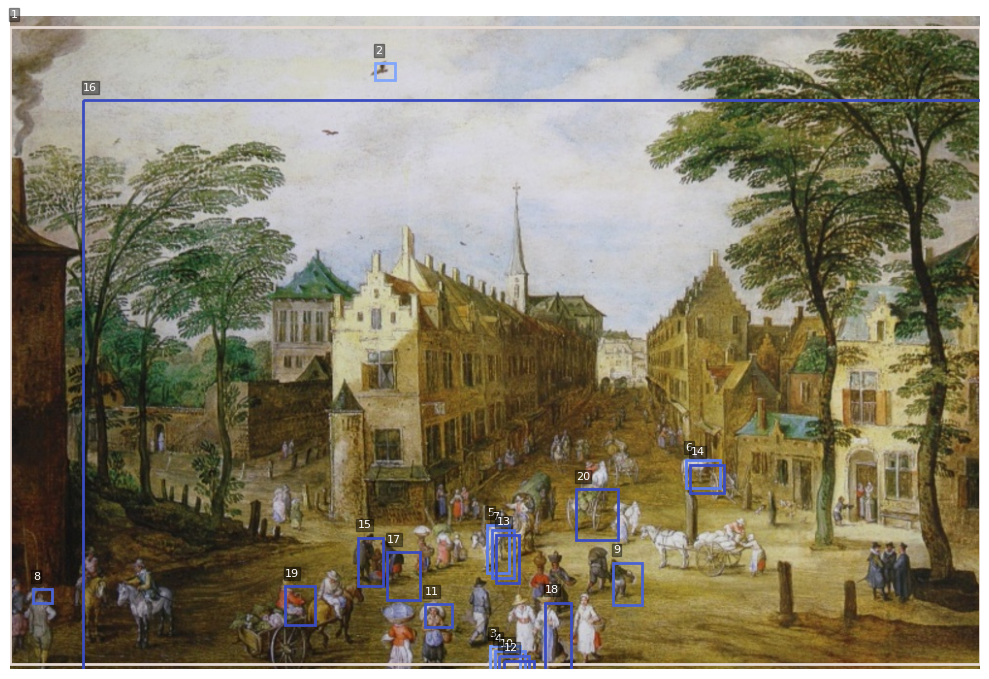

[0.8206107087755331, 0.7701432741989743, 0.7562159364997909, 0.7444327725962481, 0.7423567800019328, 0.736774373992093, 0.7273082268715272, 0.7228377179143136, 0.7227414672212299, 0.7218942914527149, 0.715941132873643, 0.7071292105161873, 0.6972685060997506, 0.6894692880550948, 0.6828450266228283, 0.6818703900337842, 0.6732052181451488, 0.6173856973380932, 0.6170104609766973]


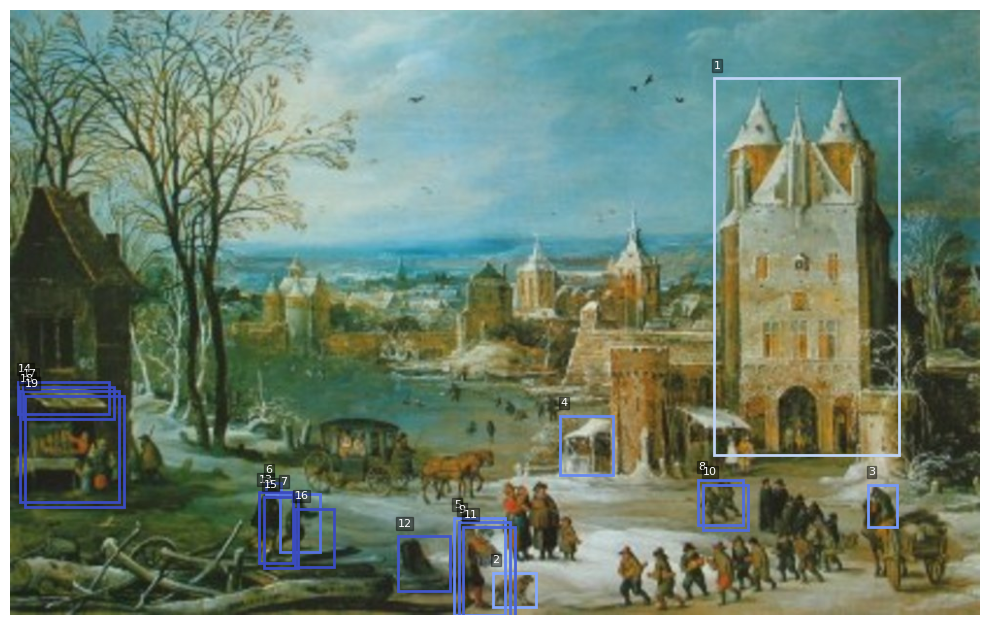

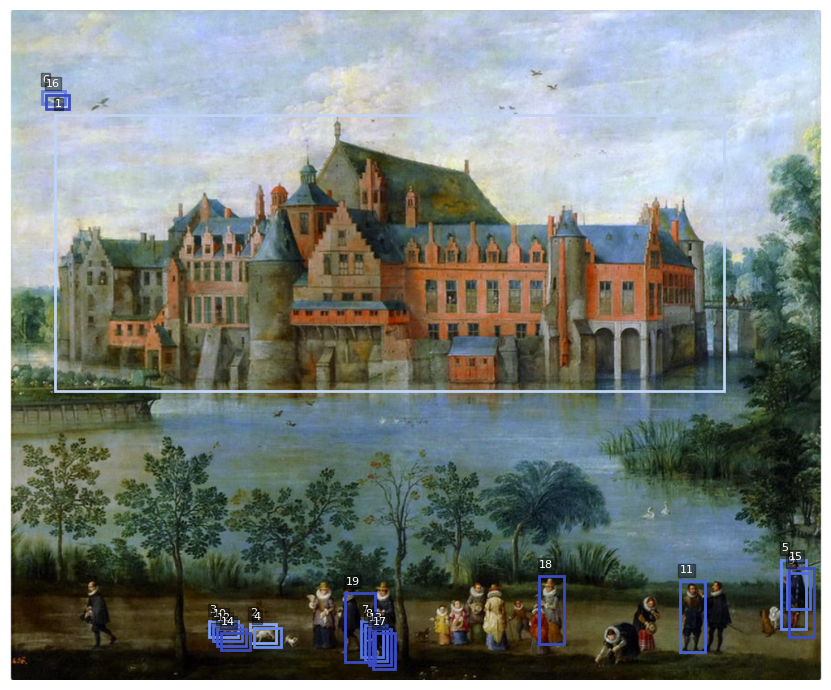

In [12]:
most_matched_images(top_matches, 2, 20)

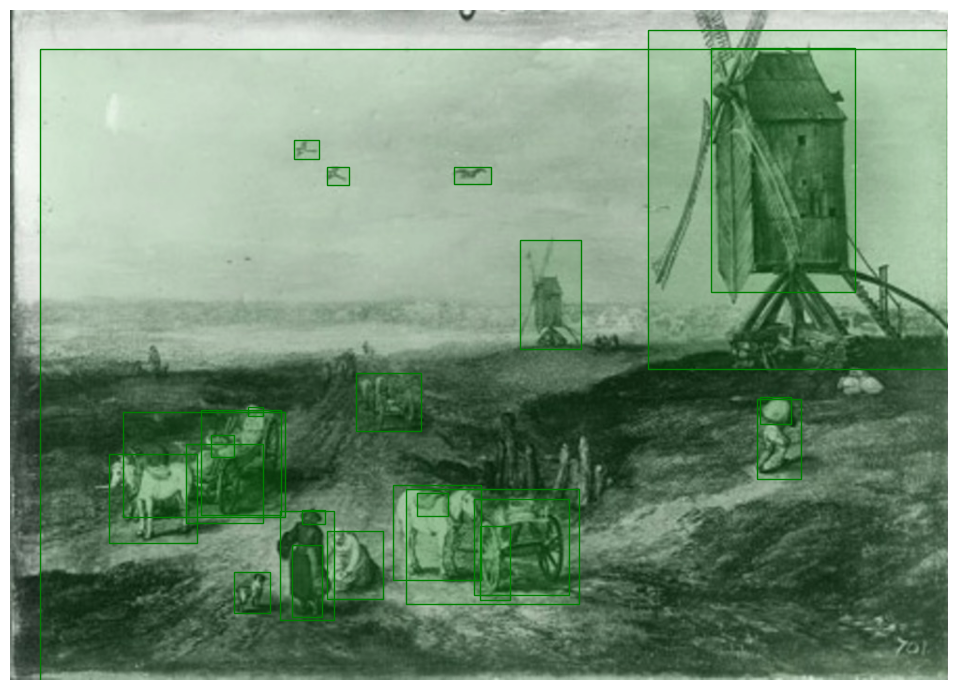

In [8]:
import json
with open('object_detection/brueg_small_detections/Windmill in a Broad Field.json', 'r') as f:
  data = json.load(f)
boxes = [item['box'] for item in data] 
t_boxes = [(b['x1'], b['y1'], b['x2'], b['y2']) for b in boxes]

colors = []

for i in range(50):
  colors.append('green')

draw_bounding_boxes('datasets/brueg_small/Windmill in a Broad Field.jpg', t_boxes, colors )